In [1]:
import open_clip
import torch
pretrained_model, train_preprocess, val_preprocess = open_clip.create_model_and_transforms(
            'ViT-B-32', pretrained='laion2b_s34b_b79k')

from utils.get_data import data
from utils.get_data import get_data
from utils.data_utils import build_subset, split_train_and_val
import warnings
warnings.simplefilter("ignore")

torch.manual_seed(1)
torch.cuda.manual_seed(1) if torch.cuda.is_available() else None

# set dataset
dataset = ['Painting', 'Real', 'Quickdraw']

# initialize clients
# client image encoder is the same as the global image encoder
cds = []
for id, data_name in enumerate(dataset):
    cd = get_data(data_name, train_preprocess, val_preprocess, f'./data/{data_name}', 128, 12)
    cd = build_subset(cd, 3)
    cd = split_train_and_val(cd)
    cds.append(cd)

with torch.no_grad():
    domain_image_represents, domain_labels = [], []
    for i in range(3):
        image_represents, labels = [], []
        for image, label in cds[i].train_loader:
            image_represent = pretrained_model.encode_image(image)
            image_represents.append(image_represent)
            labels.append(label)
        domain_image_represents.append(torch.cat(image_represents, dim=0))
        domain_labels.append(torch.cat(labels, dim=0))

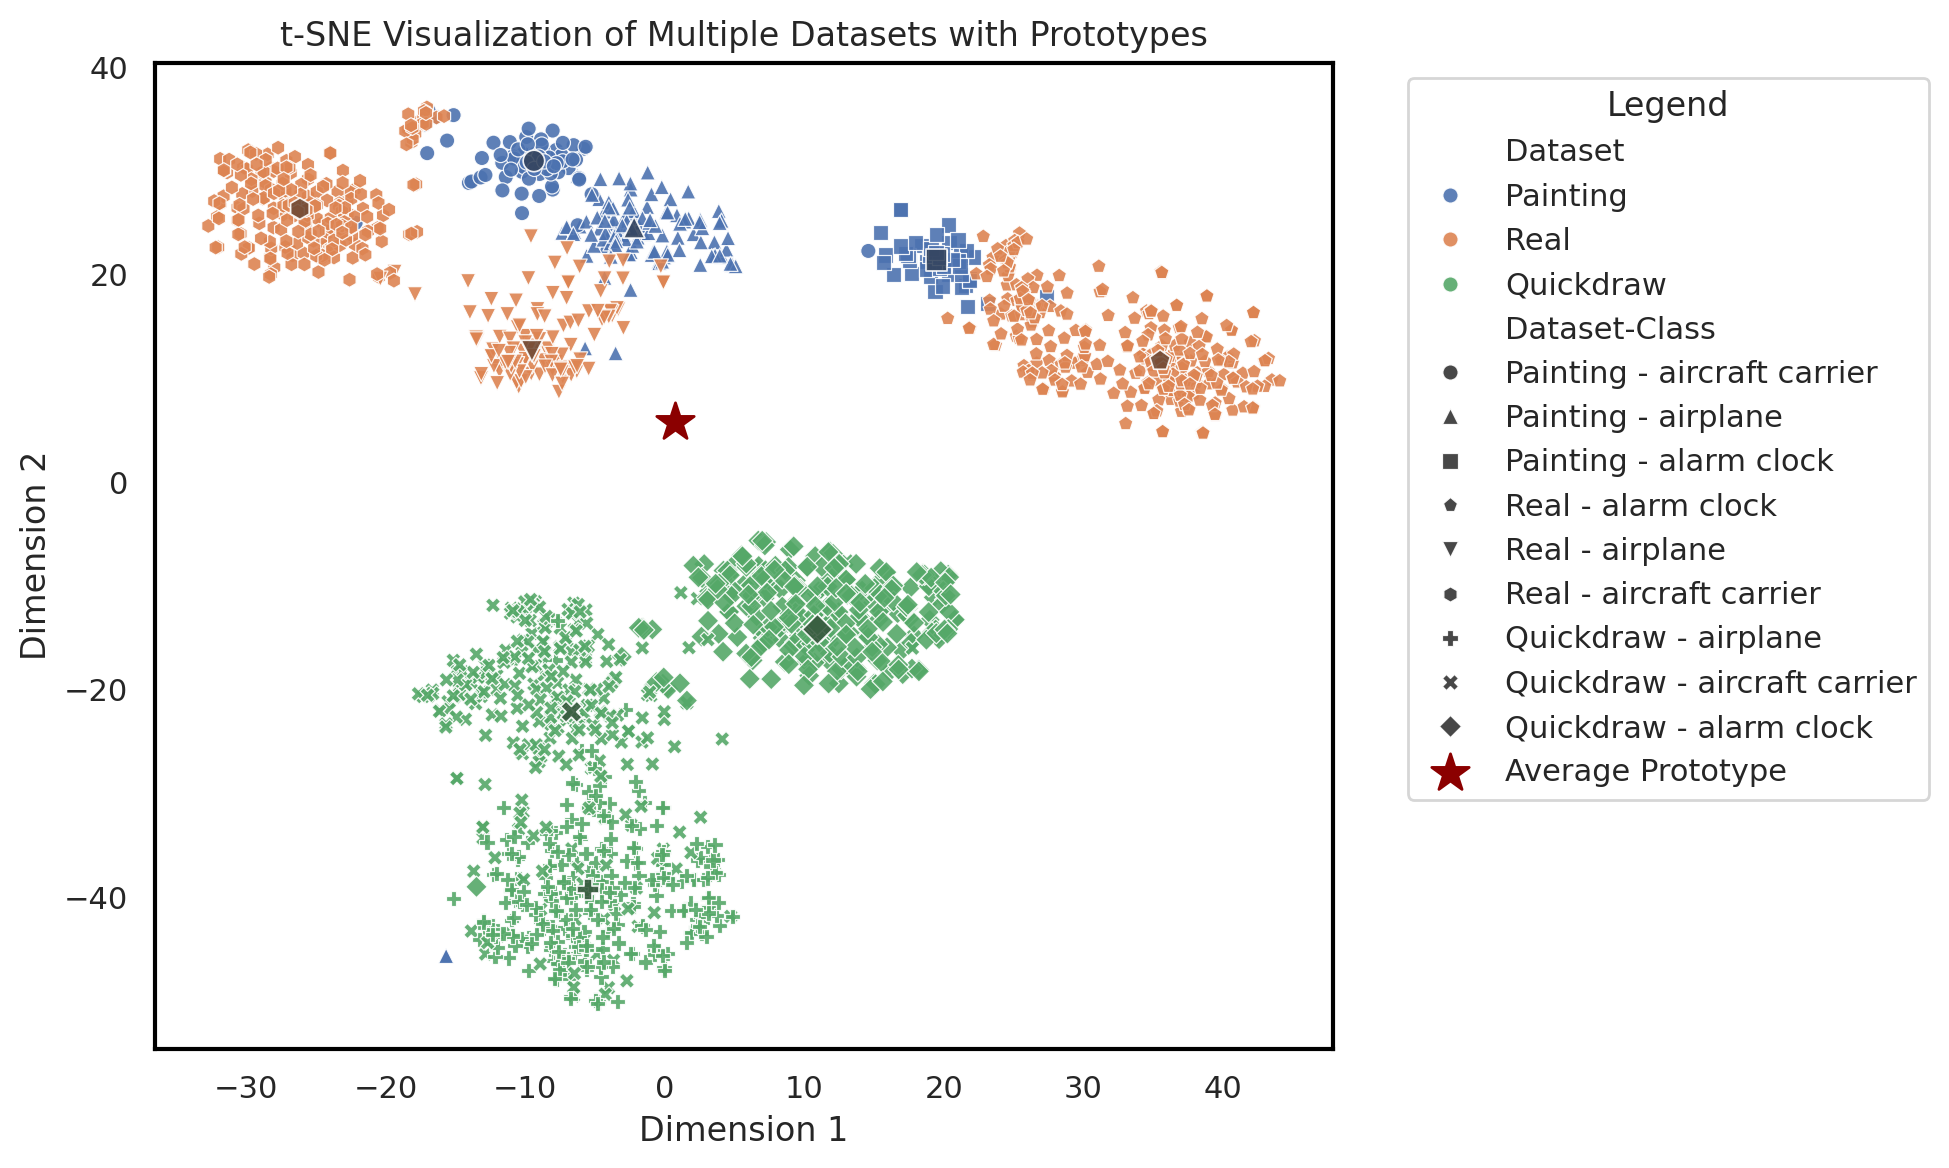

In [11]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

domains = ['Painting', 'Real', 'Quickdraw']
class_names = cd.classnames
class_dict = {0: class_names[0], 1: class_names[1], 2: class_names[2]}


class_names_map = {
    domains[0]: class_dict,
    domains[1]: class_dict,
    domains[2]: class_dict
}

markers = {
    'Painting - aircraft carrier': 'o', 'Painting - airplane': '^', 'Painting - alarm clock': 's',
    'Real - aircraft carrier': 'h', 'Real - airplane': 'v', 'Real - alarm clock': 'p',
    'Quickdraw - aircraft carrier': 'X', 'Quickdraw - airplane': 'P', 'Quickdraw - alarm clock': 'D'
}

prototypes = []
prototype_labels = []
prototype_domains = []

for domain_idx, (features, labels) in enumerate(zip(domain_image_represents, domain_labels)):
    domain = domains[domain_idx]
    for label in range(3):
        mask = labels == label
        prototype = features[mask].mean(dim=0).unsqueeze(0)
        prototypes.append(prototype)
        prototype_labels.append(np.array([label]))
        prototype_domains.append(np.array([domain]))

data = np.concatenate([x.numpy() for x in domain_image_represents] + [x.numpy() for x in prototypes])
labels = np.concatenate([x.numpy() for x in domain_labels] + prototype_labels)
domain_indicator = np.concatenate([np.full(shape=len(x), fill_value=domains[i]) for i, x in enumerate(domain_image_represents)] + prototype_domains)

tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(data)

combined_df = pd.DataFrame({
    'Dimension 1': transformed_data[:, 0],
    'Dimension 2': transformed_data[:, 1],
    'Label': labels,
    'Dataset': domain_indicator,
    'Prototype': ['Data']*sum(len(x) for x in domain_image_represents) + ['Prototype']*len(prototypes)
})

combined_df['Class'] = combined_df.apply(lambda row: class_names_map[row['Dataset']][row['Label']], axis=1)
combined_df['Dataset-Class'] = combined_df['Dataset'] + ' - ' + combined_df['Class']

palette = sns.color_palette("deep", len(combined_df['Dataset'].unique()))

def darken_palette(original_palette, factor=0.6):
    darkened_palette = [sns.dark_palette(color, n_colors=100, reverse=True)[int(100*factor)] for color in original_palette]
    return darkened_palette

dark_palette = darken_palette(palette)

scatter = plt.figure(figsize=(10, 6), dpi=200)
sns.set_context('talk')
sns.set_theme(style="white")
custom_style = {
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.5,
    'grid.linestyle': '--',
    'grid.alpha': 0.7
}
plt.rcParams.update(custom_style)

sns.scatterplot(
    data=combined_df[combined_df['Prototype']=='Data'],
    x='Dimension 1', y='Dimension 2',
    hue='Dataset', style='Dataset-Class',
    markers=markers,
    palette=palette,
    s=30, alpha=0.9
)

scatter = sns.scatterplot(
    data=combined_df[combined_df['Prototype']=='Prototype'],
    x='Dimension 1', y='Dimension 2',
    hue='Dataset', style='Dataset-Class',
    palette=dark_palette,
    markers=markers,
    s=60, alpha=0.9,
    legend=None,
)

prototypes_df = combined_df[combined_df['Prototype'] == 'Prototype']

average_prototype = prototypes_df[['Dimension 1', 'Dimension 2']].mean()
plt.scatter(
    average_prototype['Dimension 1'], average_prototype['Dimension 2'],
    color='darkred',
    marker='*',
    s=200,
    label='Average Prototype'
)

handles, labels = scatter.get_legend_handles_labels()

# new_labels = labels[:len(combined_df['Dataset'].unique())] + labels[-len(combined_df['Dataset-Class'].unique()):]
# new_handles = handles[:len(combined_df['Dataset'].unique())] + handles[-len(combined_df['Dataset-Class'].unique()):]
new_labels = labels[:14]
new_handles = handles[:14]

plt.legend(new_handles, new_labels, title='Legend', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE Visualization of Multiple Datasets with Prototypes')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.savefig('t-SNE_visualization_prototypes.pdf')
plt.show()

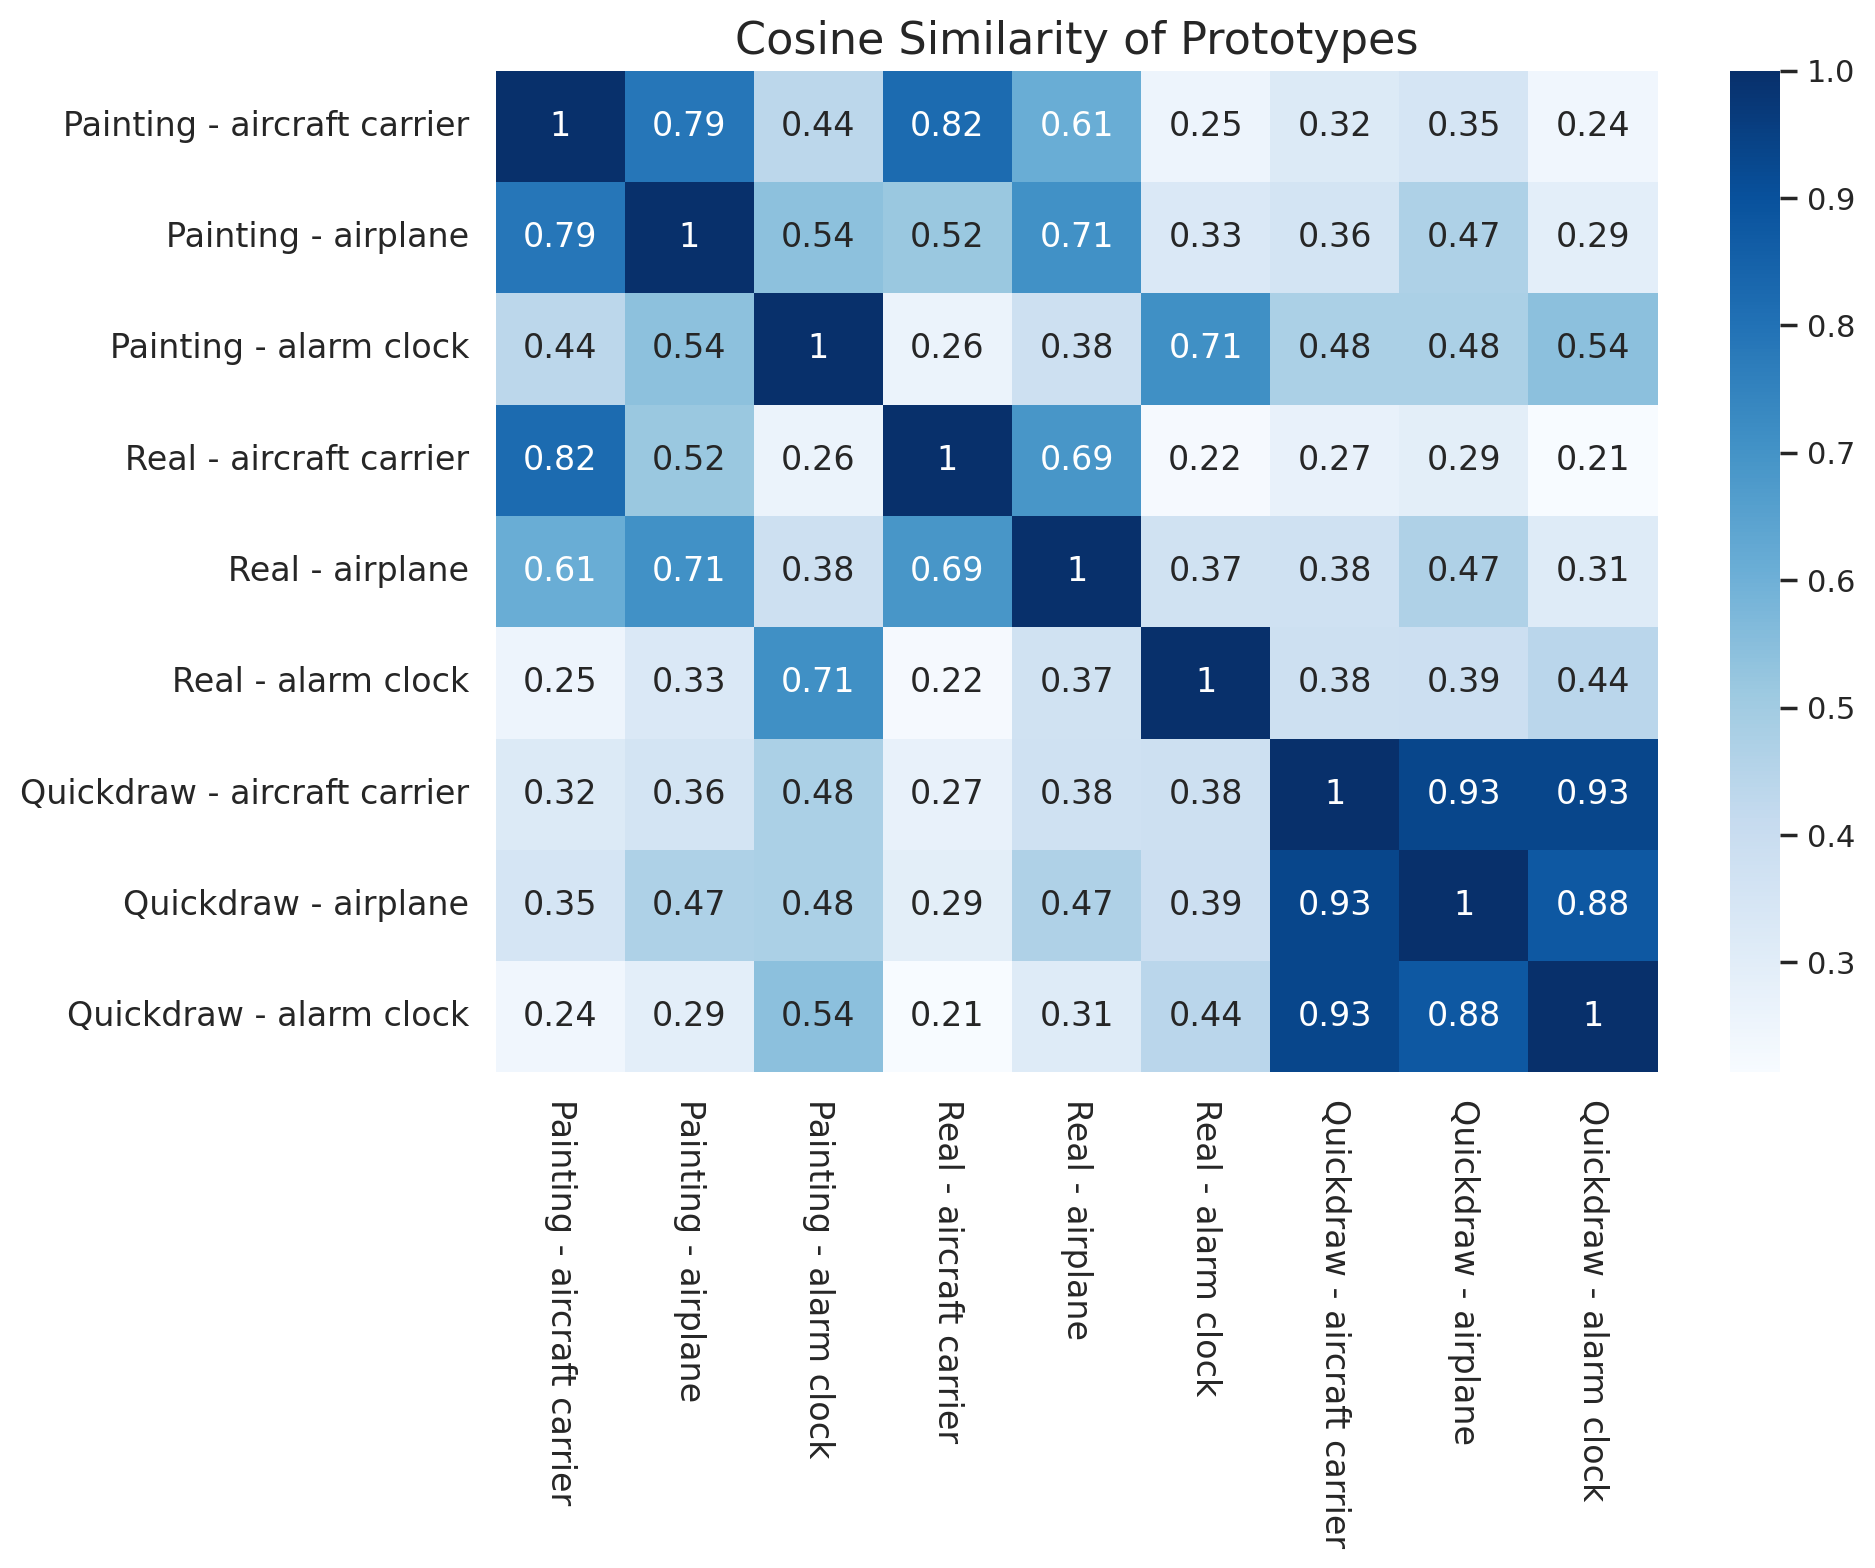

In [29]:
prototype_dict = {}
for i in range(3):
    for j in range(3):
        domain_label = domains[i] + ' - ' + class_names[j]
        prototype_dict[domain_label] = prototypes[i*3+j]

# draw heatmap of prototype cosine similarity
sim_matrix = np.zeros((9, 9))
for i in range(9):
    for j in range(9):
        sim_matrix[i, j] = torch.nn.functional.cosine_similarity(prototypes[i], prototypes[j]).item()

plt.figure(dpi=200, figsize=(10, 8))
sns.heatmap(sim_matrix, annot=True, cmap='Blues', xticklabels=list(prototype_dict.keys()), yticklabels=list(prototype_dict.keys()))
plt.title('Cosine Similarity of Prototypes', fontsize=16)
plt.xticks(rotation=270, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig('../figures/prototype_similarity.pdf')
plt.show()